In [1]:
#|code-fold: true
#|code-summary: "Importing utilities (click to show/hide)"


import torch
import fastcore.all as fc

from torch import nn
from torch.nn import init

from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *
from tinyai.sgd import *
from tinyai.resnet import *
from tinyai.augment import *

from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset


import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms

from operator import attrgetter,itemgetter
from functools import partial
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt

from torch import tensor,optim
from torch.optim import lr_scheduler

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
import logging
logging.disable(logging.WARNING)
mpl.rcParams['image.cmap'] = 'gray_r'

set_seed(42)

# tinyai

about :

## How to use

### Callbacks
tinyai has many callbacks you can or edit use to customize your training process.

- `DeciceCB` - Callback to set device for model and data.
- `BatchTransformCB` - Callback to apply a transform to a batch of data.
- `LRFinderCB` - Callback to find the best learning rate.
- `MetricsCB` - Callback to calculate metrics.
- `ProgressCB` - Callback to show progress bar during trainig
- `SingleBatchCB` - Callback to train only one batch.
- `TrainCB` - Callback with base methods(predict,backward,step) to train model. It's intagrated in TrainLearner.

- `RecorderCB` - Allows to record(save each epoch) stats fore example for lr.
- `BaseSchedCB` - Callback that allows to intagrate schedulers.
- `EpochSchedCB` - Same as BaseSchedCb, but updates after Epoch.


### Exaple of tinyai use 



#### Loading in the data

In [2]:

dsd = load_dataset("fashion_mnist")

# We can easily transform the data.
xmean,xstd = 0.28, 0.35
@inplace
def transformi(b): b['image'] = [(TF.to_tensor(o)-xmean)/xstd for o in b['image']]

tds = dsd.with_transform(transformi)

# Than load our data into DataLoaders
dls = DataLoaders.from_dd(tds, batch_size=1024, num_workers=4)

### Training


accuracy,loss,epoch,train
0.719,0.801,0,train
0.839,0.444,0,eval
0.870,0.359,1,train
0.864,0.376,1,eval


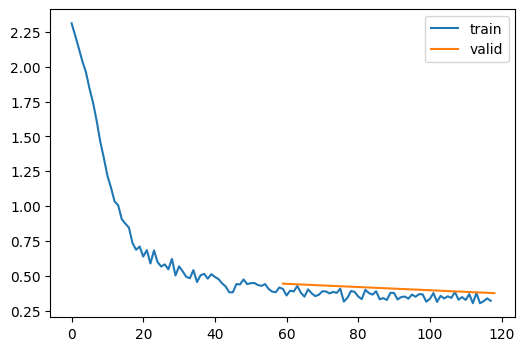

In [3]:
lr, epochs = 1e-2, 2

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)


learn.fit(epochs)

### Data Augmentation

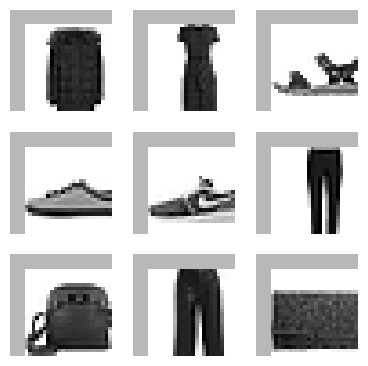

In [4]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[SingleBatchCB(), augcb])
learn.show_image_batch(max_n = 9, imsize=(1.5))

### Recorder

accuracy,loss,epoch,train
0.772,0.647,0,train
0.853,0.398,0,eval
0.880,0.327,1,train
0.877,0.336,1,eval


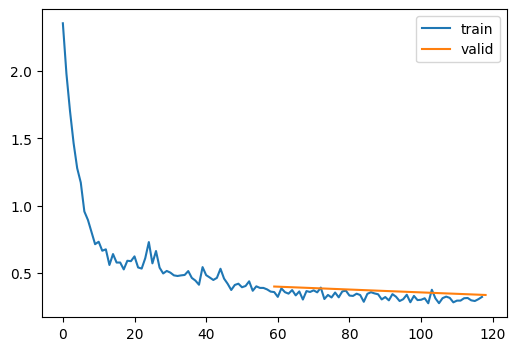

In [9]:
def _lr(cb): return cb.pg['lr']
def _beta1(cb): return cb.pg['betas'][0]

record = RecorderCB(lr=_lr, mom=_beta1)

lr, epochs = 6e-2, 2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), record]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

learn.fit(epochs)

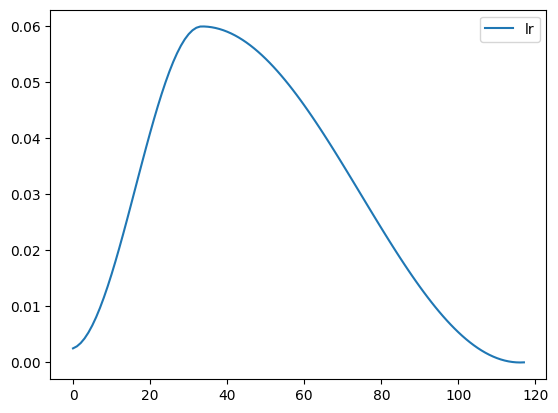

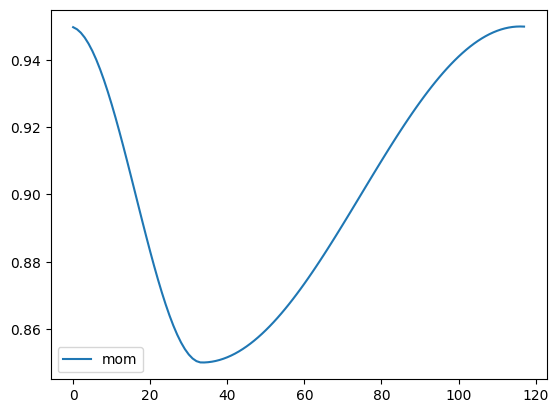

In [10]:

record.plot()

### Hooks

tinyai has a simple hook system that allows you to easily add hooks to your model, for example we can add a hook to record the mean and std of the activations of each layer.


In [7]:
#| code-fold: true
#| code-summary: "Activation Stats Class (click to show/hide)"
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop):
        super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for layer, h in enumerate(self):
            ax = axes.flat[layer]
            im = ax.imshow(get_hist(h), origin='lower')  # Using imshow directly

            # Add labels, title, and colorbar for clarity
            ax.set_xlabel("Batch Number")
            ax.set_ylabel("Activation Value")
            ax.set_title(f"Layer {layer} Activations")
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label("Frequency")
        plt.tight_layout()  # Prevent overlap

    def dead_chart(self, figsize=(11,5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for layer, h in enumerate(self):
            ax = axes.flatten()[layer]
            ax.plot(get_min(h), linewidth=3)
            ax.set_ylim(0,1)
            ax.set_xlabel("Batch Number")
            ax.set_ylabel("Activation Value")
            ax.set_title(f"Layer {layer} Dead Activations")
        plt.tight_layout()  # Prevent overlap

    def plot_stats(self, figsize=(10,4)):
        fig, axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in (0, 1):
                axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        axs[0].set_xlabel("Batch")
        axs[1].set_xlabel("Batch")
        axs[0].set_ylabel("Mean Activation Value")
        axs[1].set_ylabel("Standard Deviation of Activation Value")
        plt.legend(fc.L.range(len(self)))

accuracy,loss,epoch,train
0.311,2.002,0,train
0.516,1.527,0,eval
0.682,0.854,1,train
0.719,0.722,1,eval


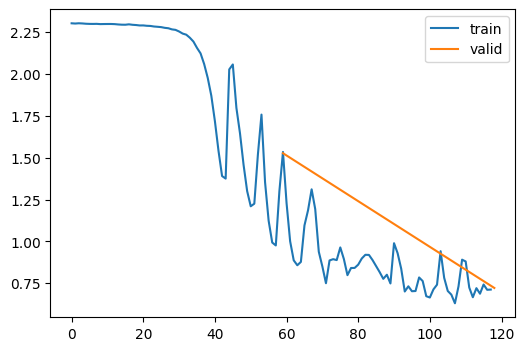

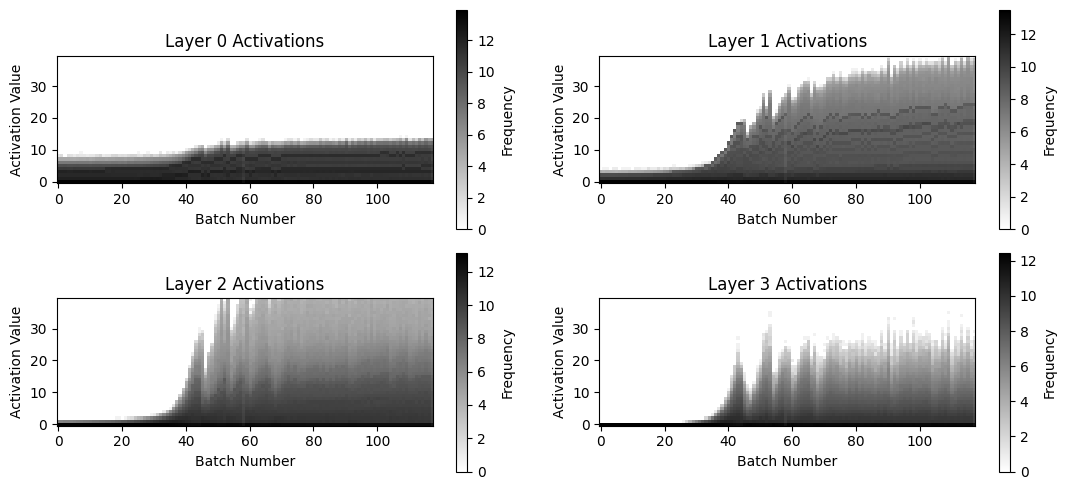

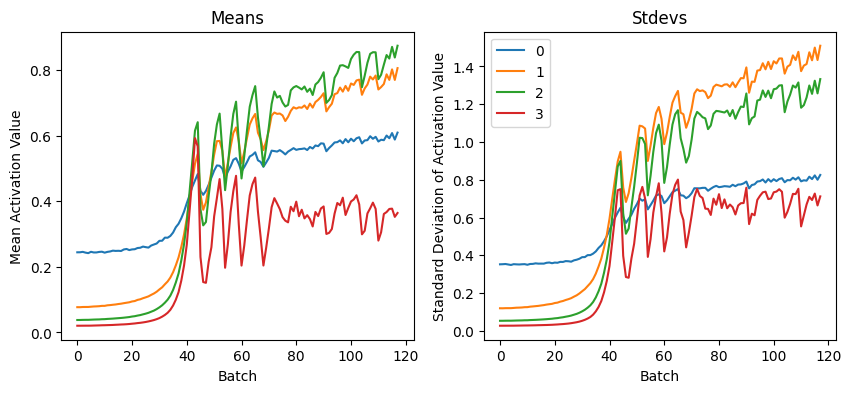

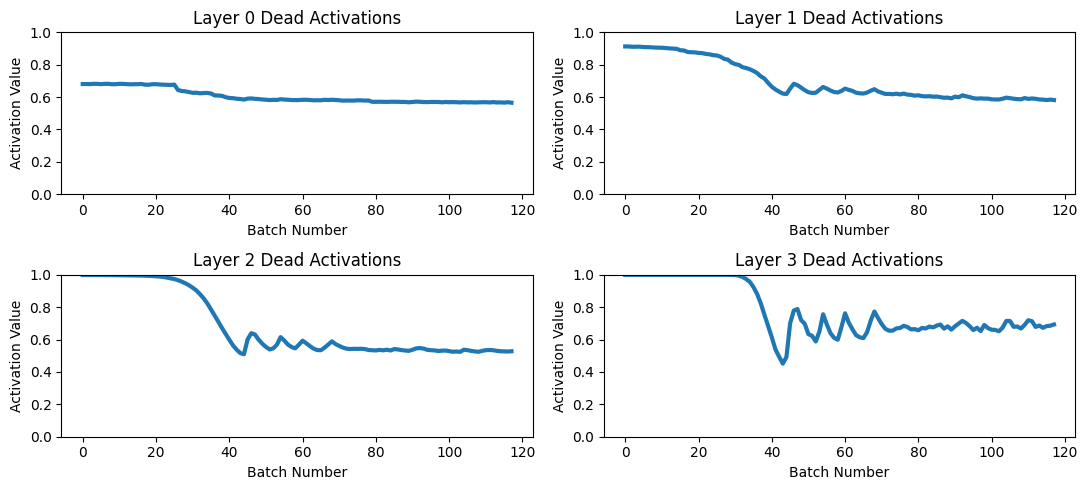

In [8]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

astats.color_dim()

astats.plot_stats()

astats.dead_chart()

#### Future
Future of this project: 

- Things from the course 
- Add poetry for package management 
- Add tests 
- Maybe move this package to tinygrad or mojo. 
- Think about reducing the number of dependencies. 